## Q1

<b>Data Analysis.<br>
<b>Concerns about the data.<br>
<b>Suggestions on other useful data to collect.

In [114]:
# Import libraries for processing
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import mean
from numpy import std

from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from collections import defaultdict

from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, randint

# Import libraries for modelling
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import os, time, sys
warnings.filterwarnings("ignore")

In [115]:
#Functions & Utils
        
def value_count(df, value):
    val_count = {}
    if value == 'NA':
        for col in df.columns:
            col_value = 0
            for val in df[col].isnull():
                if val == True:
                    col_value += 1
            val_count[col] = [col_value, '{:0.2f}%'.format((float(col_value)/len(df))*100)]
        return val_count
    else:
        for col in df.columns:
            col_value = 0
            for val in df[col] == value:
                if val == True:
                    col_value += 1
            val_count[col] = [col_value, '{:0.2f}%'.format((float(col_value)/len(df))*100)]
        return val_count
    
def fill_col_with_median(df):
    for col in df.columns:
        df[col] = df[col].fillna(df[col].median())
    return df

def remove_outliers(df):
    for col in df.columns:
        df[col] = replace_outlier(df[col])
    return df

def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (min_val, max_val) = np.percentile(data, [diff, 100 - diff])
    return ((data < min_val) | (data > max_val))

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    is_outlier = []
    for val in data:
        if val/std > threshold:
            is_outlier.append(True)
        else:
            is_outlier.append(False)
    return is_outlier

def outlier_vote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(data.index, x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plot_outlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote])):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile based outliers', **kwargs)
    axes[1].set_title('MAD based outliers', **kwargs)
    axes[2].set_title('STD based outliers', **kwargs)
    axes[3].set_title('Majority vote based outliers', **kwargs)
    fig.suptitle('Comparing outlier tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plot_outlier_free(x):
    fig, axes = plt.subplots(nrows=4)
    n_outliers = []
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote])):
        tf_outlier = list(zip(x, func(x)))
        n_outliers.append(len([index for (index, bol) in tf_outlier if bol == True]))
        outlier_free = [index for (index, bol) in tf_outlier if bol == True]
        sns.distplot(outlier_free, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile based outliers, removed: {r}'.format(r=n_outliers[0]), **kwargs)
    axes[1].set_title('MAD-based outliers, removed: {r}'.format(r=n_outliers[1]), **kwargs)
    axes[2].set_title('STD-based outliers, removed: {r}'.format(r=n_outliers[2]), **kwargs)
    axes[3].set_title('Majority vote based outliers, removed: {r}'.format(r=n_outliers[3]), **kwargs)
    fig.suptitle('Outlier removed by method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlier_ratio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote]
    outlier_dict = {}
    for func in functions:
        func_result = func(data)
        count = 0
        for val in func_result:
            if val == True:
                count += 1 
        outlier_dict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlier_dict

def replace_outlier(data, method = outlier_vote, replace='median'):
    '''replace: median (auto)
    'min_upper' which is the upper bound of the outlier detection'''
    vote = outlier_vote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['place_holder', 'outlier'])
    if replace == 'median':
        replace = x['place_holder'].median()
    elif replace == 'min_upper':
        replace = min([val for (val, vote) in list(zip(data, vote)) if vote == True])
        if replace < data.mean():
            print('There are outliers lower than the sample mean')
            return 'There are outliers lower than the sample mean'
    place_holder_new = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            place_holder_new.append(replace)
        else:
            place_holder_new.append(x.iloc[i][0])
    return place_holder_new

### Take a look at the dataset and get summary statistics

In [116]:
# Load data
stores = pd.read_csv('train.csv')
stores_test = pd.read_csv('test.csv')

In [117]:
# Take a look at the first few rows
stores.head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
0,464,17.600541,0.0,18.10,no,NaN,2.926,29.0,2.9084,All transport options,666,20.2,368.74,4.5325,-0.399933,c_40
1,504,0.603556,20.0,3.97,no,14.85,4.520,10.6,2.1398,Average transport options,264,13.0,388.37,1.8150,2.216308,c_80
2,295,0.606810,0.0,6.20,no,7.70,2.981,31.9,3.6715,Many transport options,307,17.4,378.35,2.9125,0.166920,c_53
3,187,0.012385,55.0,2.25,no,1.95,3.453,68.1,7.3073,No transport options,300,15.3,394.72,2.0575,-0.083804,c_65
4,193,0.016182,100.0,1.32,no,3.05,3.816,59.5,8.3248,Average transport options,256,15.1,392.90,0.9875,0.962693,c_97


Data dict as given<br>

location_id: id of Tesco property location<br>
normalised_sales: normalised sales value of Tesco store<br>
crime_rate: crime rate in the area<br>
household_size: mean household size in the area<br>
household_affluency: mean household affluency in the area<br>
public_transport_dist: index of public transport availability in the area<br>
proportion_newbuilds: proportion of newly built property in the area<br>
property_value: average property value in the area<br>
commercial_property: percentage of commercial properties in the area<br>
school_proximity: average school proximity in the area<br>
transport_proximity: proximity of different transport modes<br>
new_store: new Tesco store opened recently<br>
proportion_nonretail: proportion of non-retail commercial properties in the area<br>
competitor_density: density of competitor retailers<br>
proportion_flats: proportion of blocks of flats in the area<br>
county: county code of the area

In [118]:
# Check data types
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location_id             320 non-null    int64  
 1   crime_rate              320 non-null    float64
 2   proportion_flats        320 non-null    float64
 3   proportion_nonretail    320 non-null    float64
 4   new_store               320 non-null    object 
 5   commercial_property     291 non-null    float64
 6   household_size          320 non-null    float64
 7   proportion_newbuilds    320 non-null    float64
 8   public_transport_dist   320 non-null    float64
 9   transport_availability  320 non-null    object 
 10  property_value          320 non-null    int64  
 11  school_proximity        257 non-null    float64
 12  competitor_density      320 non-null    float64
 13  household_affluency     320 non-null    float64
 14  normalised_sales        320 non-null    fl

-  <b>The features new_store, transport_availability and county may need to be changed to category for modelling later

In [119]:
# Numerical and Categorical features
numerical = ['crime_rate', 'proportion_flats', 'proportion_nonretail', 'commercial_property', 'household_size', 
             'proportion_newbuilds', 'public_transport_dist', 'property_value', 'school_proximity', 'competitor_density', 
             'household_affluency']

categorical = ['new_store','transport_availability', 'county']

target = ['normalised_sales']
all_num = numerical + target
all_cat = categorical + target

In [120]:
# Data types look ok, check summary stats
stores.describe()

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,property_value,school_proximity,competitor_density,household_affluency,normalised_sales
count,320.000000,320.000000,320.000000,320.000000,291.000000,320.000000,320.000000,320.000000,320.000000,257.000000,320.000000,320.000000,320.000000
mean,252.387500,3.596375,10.673438,11.307906,16.868557,3.252803,31.849063,3.718765,408.834375,18.589494,359.657562,3.144008,-0.016967
std,145.600582,7.176342,22.579232,7.032693,73.806051,0.695442,27.845777,1.984765,170.888974,2.075529,86.048632,1.774041,0.978561
min,1.000000,0.007142,0.000000,0.740000,1.750000,0.561000,0.000000,1.137000,188.000000,13.000000,3.500000,0.432500,-1.936974
25%,126.500000,0.087937,0.000000,5.130000,5.450000,2.879750,6.350000,2.138075,277.000000,17.400000,376.722500,1.803750,-0.585250
50%,251.500000,0.289681,0.000000,9.900000,9.400000,3.197500,23.400000,3.095750,330.000000,19.100000,392.205000,2.808750,-0.143759
75%,377.250000,4.063553,12.500000,18.100000,14.050000,3.597250,54.450000,5.116700,666.000000,20.200000,396.352500,4.091875,0.243227
max,506.000000,51.693093,100.000000,27.740000,1009.000000,5.725000,94.000000,10.710300,711.000000,21.200000,396.900000,9.492500,2.968477


-  <b>From the summary statistics above, we can see that commercial_property, described as a percentage, has atleast 1 entry geater than 100% (1009%)

In [121]:
# Find the rows where percentage is greater than 100
stores.loc[stores['commercial_property'] > 100].head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
96,90,0.138640,0.0,6.91,no,1009.0,3.069,60.0,5.7209,No transport options,233,17.9,389.39,2.3875,-0.171012,c_48
103,394,0.102864,0.0,2.46,no,123.0,4.155,7.8,2.7006,No transport options,193,NaN,394.12,1.2050,1.649456,c_68
224,283,10.541872,0.0,18.10,no,767.0,3.185,1.3,2.2616,All transport options,666,20.2,396.90,4.5325,-0.944983,c_45


In [122]:
# Plot commercial_property
fig = px.box(stores, y="commercial_property", points='all')
fig.show()

<b>I've decided to not remove these rows but to remove the specific entries as the other features in the record seem reasonable and are potentially useful.

In [123]:
# remove commercial_property > 100%
to_delete = [96, 103, 224]
for num in to_delete:
    stores.at[num, 'commercial_property'] = np.nan


In [124]:
# Find the rows where percentage is greater than 100
stores.loc[stores['commercial_property'] > 100].head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county


### Get a sense of missing values in the dataset

In [125]:
value_count(stores, 'NA')

{'location_id': [0, '0.00%'],
 'crime_rate': [0, '0.00%'],
 'proportion_flats': [0, '0.00%'],
 'proportion_nonretail': [0, '0.00%'],
 'new_store': [0, '0.00%'],
 'commercial_property': [32, '10.00%'],
 'household_size': [0, '0.00%'],
 'proportion_newbuilds': [0, '0.00%'],
 'public_transport_dist': [0, '0.00%'],
 'transport_availability': [0, '0.00%'],
 'property_value': [0, '0.00%'],
 'school_proximity': [63, '19.69%'],
 'competitor_density': [0, '0.00%'],
 'household_affluency': [0, '0.00%'],
 'normalised_sales': [0, '0.00%'],
 'county': [0, '0.00%']}

#### Options to handle records with missing data.
Consider whether the data is missing at random or missing for a systematic reason, then
-  Remove all rows (or columns) with any missing data
-  Try to impute the missing value, this may involve judgment calls (e.g. use column mean, median)
-  Develop another model to predict the missing values.

#### commercial_property is missing 9.06% and school_proximity is missing 19.69%
#### commercial_property and school proximity_variables. Compare mean v median as replacement

In [126]:
# mean
ns_mean = stores['normalised_sales'].fillna(stores['normalised_sales'].mean())
cp_mean = stores['commercial_property'].fillna(stores['commercial_property'].mean())
sp_mean = stores['school_proximity'].fillna(stores['school_proximity'].mean())
# median
ns_median = stores['normalised_sales'].fillna(stores['normalised_sales'].median())
cp_median = stores['commercial_property'].fillna(stores['commercial_property'].median())
sp_median = stores['school_proximity'].fillna(stores['school_proximity'].median())

cp_missing_joint = stores['normalised_sales'].isnull() | stores['commercial_property'].isnull()
sp_missing_joint = stores['normalised_sales'].isnull() | stores['school_proximity'].isnull()

In [127]:
# create a dictionary to indicate different colors, missing values will be orange
colour_choice_dict = {True: (1.0, 0.55, 0.0, 1.0), False: (0.11, 0.65, 0.72, 0.1)}
# create a column with color values
colour_col = [colour_choice_dict[val] for val in cp_missing_joint]

Text(0, 0.5, 'normalised_sales')

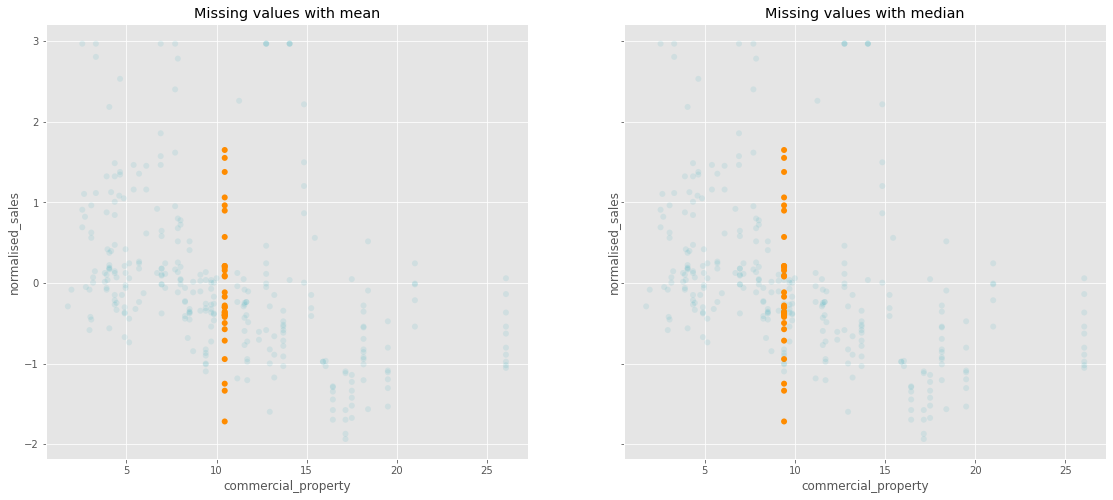

In [128]:
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(19, 8))
ax1.scatter(cp_mean, ns_mean, c = colour_col, linewidth=0)
ax1.set_title('Missing values with mean')
ax1.set_xlabel('commercial_property')
ax1.set_ylabel('normalised_sales')
ax2.scatter(cp_median, ns_median, c = colour_col, linewidth=0)
ax2.set_title('Missing values with median')
ax2.set_xlabel('commercial_property')
ax2.set_ylabel('normalised_sales')

-  We can see where the imputed values will be.There does not seem to be a big difference. Choose median.

Text(0, 0.5, 'normalised_sales')

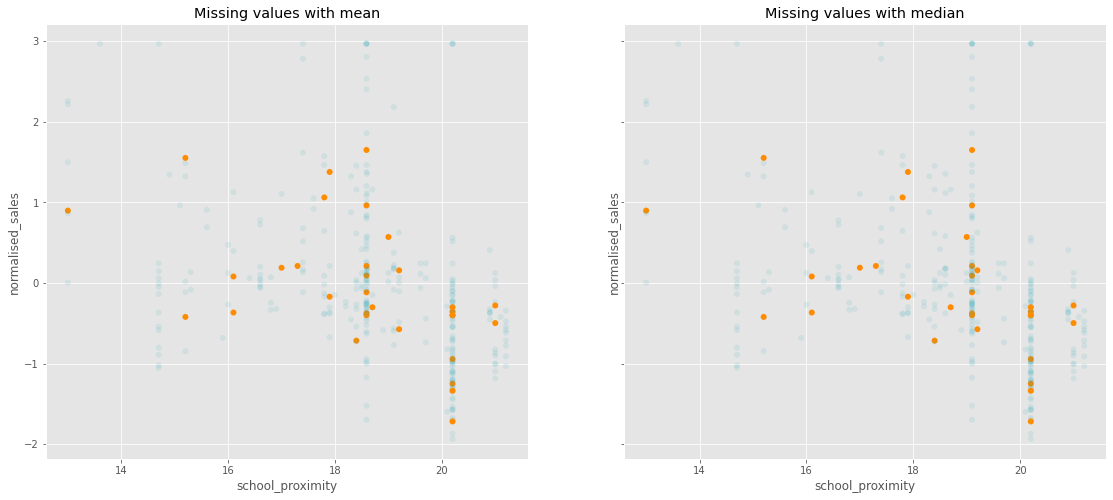

In [129]:
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(19, 8))
ax1.scatter(sp_mean, ns_mean, c = colour_col, linewidth=0)
ax1.set_title('Missing values with mean')
ax1.set_xlabel('school_proximity')
ax1.set_ylabel('normalised_sales')
ax2.scatter(sp_median, ns_median, c = colour_col, linewidth=0)
ax2.set_title('Missing values with median')
ax2.set_xlabel('school_proximity')
ax2.set_ylabel('normalised_sales')

-  Same as commercial_property, use median.

In [130]:
# Replace missing values with median
stores['commercial_property']= stores['commercial_property'].fillna(stores['commercial_property'].median())
stores['school_proximity']= stores['school_proximity'].fillna(stores['school_proximity'].median())

### Distribution of the target variable normalised_sales

In [131]:
fig = px.box(stores, y="normalised_sales", points='all')
fig.show()

In [132]:
hist_data = [stores['normalised_sales']]
group_labels = ['normalised_sales']
fig = ff.create_distplot(hist_data, group_labels)
fig.show()
print('min: {} max: {} mean: {} std: {}'.format(min(stores['normalised_sales']), max(stores['normalised_sales']), stores['normalised_sales'].mean(), stores['normalised_sales'].std()))

min: -1.9369739683900924 max: 2.9684772596520763 mean: -0.01696673148097644 std: 0.9785613571833174


-  Normally distributed with most values between -1 and 1

### Get a sense of the outliers in the dataset

I will use 3 methods with thresholds (mean absolute deviation: threshold - 3.5, percentile: threshold - 95, standard deviation: threshold - 3) to vote for values that will be classed as outliers.<br>

My thinking is that Random Forests use trees, which split the data into groups (repeatedly) according to whether a case is above or below a selected threshold value on a selected feature variable.  It doesn’t matter how much higher it is, for instance, just if it’s higher. Thus, input outliers don’t have extra influence, like they do in regression, for instance, where they can become known as leverage points. Also, output outliers will affect the estimate of the leaf node they are in, but not the values of any other leaf node.  Again, this is different from other methods – ones John Elder calls “consensus” methods, like regression or neural networks – where every data point affects the estimate at every other data point. Instead, tree methods are “contributory” methods, where only local points – those in the same leaf node – affect a given point’s estimate.  So output outliers have a “quarantined” effect. Thus, outliers that would wildly distort the accuracy of some algorithms have less of an effect on the prediction of a Random Forest.

In [133]:
#create palette
my_palette = ["#1E90FF", "#FFD700", "#00EEEE", "#668B8B", "#EAEAEA", "#FF3030"]
sns.set_palette(my_palette)

<b>Crime Rate feature

In [134]:
outlier_ratio(stores['crime_rate'])

{'percentile_based_outlier': [15, '4.69%'],
 'mad_based_outlier': [105, '32.81%'],
 'std_div': [11, '3.44%'],
 'outlier_vote': [11, '3.44%']}

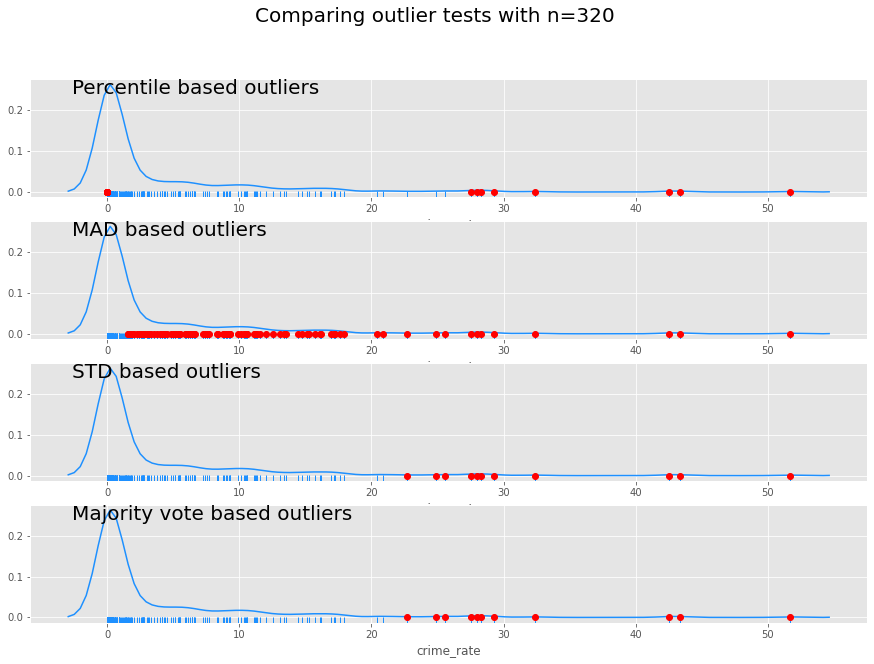

In [135]:
plot_outlier(stores['crime_rate'].sample(320))

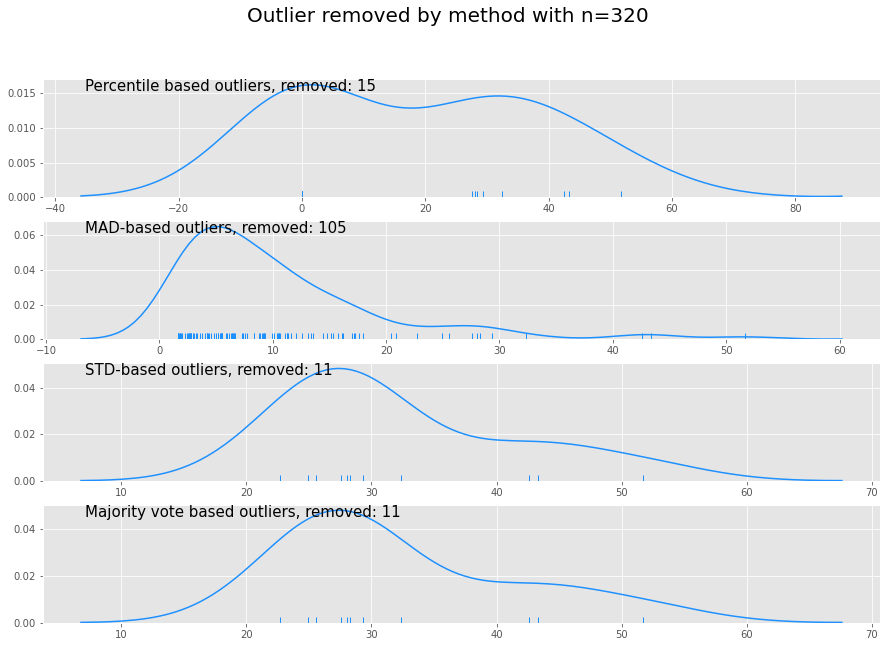

In [136]:
plot_outlier_free(stores['crime_rate'].sample(320))

In [137]:
new_crime_rate = replace_outlier(stores['crime_rate'], replace='min_upper')

In [138]:
stores['crime_rate'] = new_crime_rate
stores['crime_rate'].describe()

count    320.000000
mean       3.263035
std        5.716039
min        0.007142
25%        0.087937
50%        0.289681
75%        4.063553
max       22.695937
Name: crime_rate, dtype: float64

Show only outlier ratio summaries for the rest of the features

<b>Proportion Flats feature

In [139]:
outlier_ratio(stores['proportion_flats'])

{'percentile_based_outlier': [8, '2.50%'],
 'mad_based_outlier': [82, '25.62%'],
 'std_div': [19, '5.94%'],
 'outlier_vote': [19, '5.94%']}

In [140]:
new_proportion_flats = replace_outlier(stores['proportion_flats'], replace='min_upper')
stores['proportion_flats'] = new_proportion_flats
#stores['proportion_flats'].describe()

<b>Proportion Nonretail feature

In [141]:
outlier_ratio(stores['proportion_nonretail'])

{'percentile_based_outlier': [11, '3.44%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [20, '6.25%'],
 'outlier_vote': [4, '1.25%']}

In [142]:
new_proportion_nonretail = replace_outlier(stores['proportion_nonretail'], replace='min_upper')
stores['proportion_nonretail'] = new_proportion_nonretail
#stores['proportion_nonretail'].describe()

<b>Commercial Property feature

In [143]:
outlier_ratio(stores['commercial_property'])

{'percentile_based_outlier': [8, '2.50%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [49, '15.31%'],
 'outlier_vote': [0, '0.00%']}

In [144]:
new_commercial_property = replace_outlier(stores['commercial_property'], replace='median')
stores['commercial_property'] = new_commercial_property
#stores['commercial_property'].describe()

<b>Household Size feature

In [145]:
outlier_ratio(stores['household_size'])

{'percentile_based_outlier': [16, '5.00%'],
 'mad_based_outlier': [11, '3.44%'],
 'std_div': [306, '95.62%'],
 'outlier_vote': [12, '3.75%']}

In [146]:
new_household_size = replace_outlier(stores['household_size'], replace='median')
stores['household_size'] = new_household_size
#stores['household_size'].describe()

<b>Proportion Newbuilds feature

In [147]:
outlier_ratio(stores['proportion_newbuilds'])

{'percentile_based_outlier': [8, '2.50%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [14, '4.38%'],
 'outlier_vote': [8, '2.50%']}

In [148]:
new_proportion_newbuilds = replace_outlier(stores['proportion_newbuilds'], replace='median')
stores['proportion_newbuilds'] = new_proportion_newbuilds
#stores['proportion_newbuilds'].describe()

<b>Public Transport Dist feature

In [149]:
outlier_ratio(stores['public_transport_dist'])

{'percentile_based_outlier': [16, '5.00%'],
 'mad_based_outlier': [3, '0.94%'],
 'std_div': [53, '16.56%'],
 'outlier_vote': [8, '2.50%']}

In [150]:
new_public_transport_dist = replace_outlier(stores['public_transport_dist'], replace='median')
stores['public_transport_dist'] = new_public_transport_dist
#stores['public_transport_dist'].describe()

<b>Property Value feature

In [151]:
outlier_ratio(stores['property_value'])

{'percentile_based_outlier': [10, '3.12%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [88, '27.50%'],
 'outlier_vote': [4, '1.25%']}

In [152]:
new_property_value = replace_outlier(stores['property_value'], replace='median')
stores['property_value'] = new_property_value
#stores['property_value'].describe()

<b>School Proximity feature

In [153]:
outlier_ratio(stores['school_proximity'])

{'percentile_based_outlier': [7, '2.19%'],
 'mad_based_outlier': [6, '1.88%'],
 'std_div': [320, '100.00%'],
 'outlier_vote': [7, '2.19%']}

In [154]:
new_school_proximity = replace_outlier(stores['school_proximity'], replace='median')
stores['school_proximity'] = new_school_proximity
#stores['school_proximity'].describe()

<b>Competitor Density feature

In [155]:
outlier_ratio(stores['competitor_density'])

{'percentile_based_outlier': [8, '2.50%'],
 'mad_based_outlier': [62, '19.38%'],
 'std_div': [292, '91.25%'],
 'outlier_vote': [42, '13.12%']}

In [156]:
new_competitor_density = replace_outlier(stores['competitor_density'], replace='median')
stores['competitor_density'] = new_competitor_density
#stores['competitor_density'].describe()

In [157]:
new_competitor_density = replace_outlier(stores['competitor_density'], replace='median')
stores['competitor_density'] = new_competitor_density
#stores['competitor_density'].describe()

<b>Household Affluency feature

In [158]:
outlier_ratio(stores['household_affluency'])

{'percentile_based_outlier': [16, '5.00%'],
 'mad_based_outlier': [3, '0.94%'],
 'std_div': [40, '12.50%'],
 'outlier_vote': [8, '2.50%']}

In [159]:
new_household_affluency = replace_outlier(stores['household_affluency'], replace='median')
stores['household_affluency'] = new_household_affluency
#stores['household_affluency'].describe()

### Visualisation

In [160]:
#create palette
my_palette = ["#1E90FF", "#FFD700", "#00EEEE", "#668B8B", "#EAEAEA", "#FF3030"]
sns.set_palette(my_palette)

#### Plot categorical features

In [161]:
for cat in categorical:
    fig = px.histogram(stores, x=cat)
    fig.show()

#### Look at categorical features alongside normalised sales

In [162]:
fig = px.box(stores, y="normalised_sales", x="new_store", points='all')
fig.show()

In [163]:
fig = px.box(stores, y="normalised_sales", x="transport_availability", points='all')
fig.show()

In [164]:
fig = px.scatter(stores, x="transport_availability", y="normalised_sales", color="new_store",hover_name="county")
fig.show()

#### Questions
Are there counties where normalised_sales for <b>ALL</b> store locations are positive?<br>
Are there counties to avoid?

In [165]:
# Take a look at counties with more than 4 stores
county_extract = stores['county'].value_counts().reset_index(name="count").query("count > 4")
#county_extract
high_counties = stores[stores['county'].isin(county_extract['index'])]
#high_counties
fig = px.box(high_counties, y="normalised_sales", x="county", points='all')
fig.show()

#### Observations for categorical features
-  New stores seem to have better sales
-  Locations with many transport options seem to have better sales
-  Some counties have all stores in the county (at least 5 stores) entirely positive sales (c_68, c_83, c_94)
-  Some counties have all stores in the county (at least 5 stores) entirely negative sales (c_52, c_59, c_62)

### Correlations

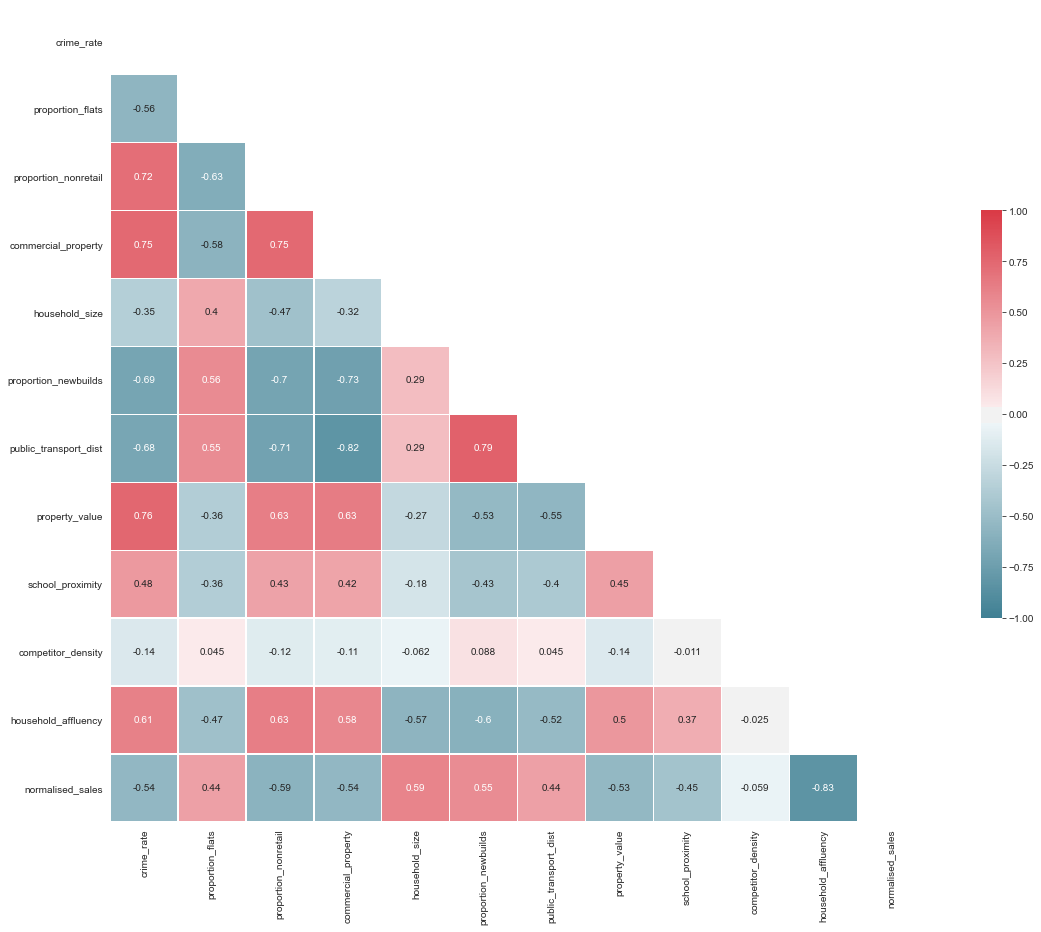

In [166]:
s = stores[all_num]
#whitegrid
sns.set_style('whitegrid')

#compute correlation matrix
corr_matrix=s.corr(method='spearman')

#show with a heatmap
plt.figure(figsize=(20,15))
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Examine relationship between normalised_sales and a few other variables
-  household_affluency (-0.83)
-  household_size (0.59)
-  proportion_nonretail (-0.59)
-  proportion_newbuilds (0.55)

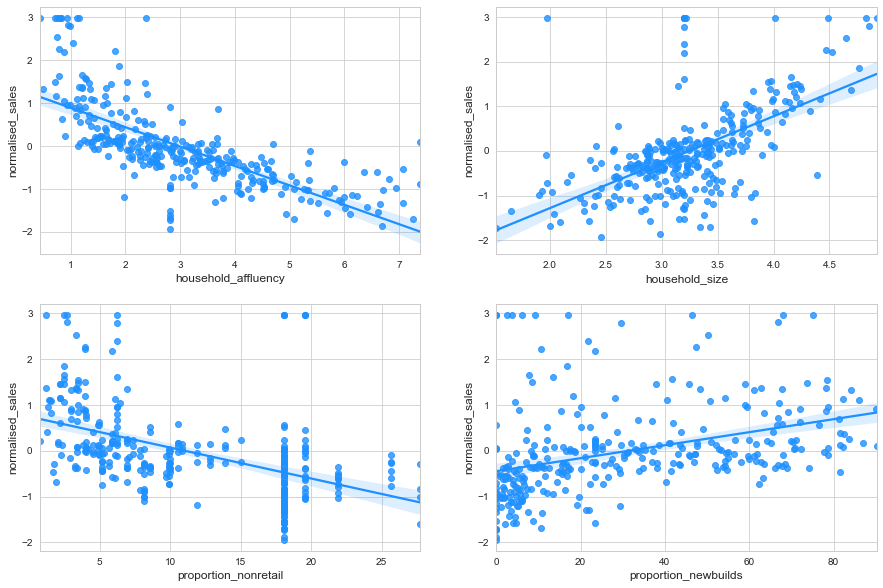

In [167]:
# Scatterplot
f, axes = plt.subplots(figsize = (15,10))
plt.subplot(221)
sns.regplot(data= stores, x='household_affluency', y='normalised_sales')
plt.subplot(222)
sns.regplot(data= stores, x='household_size', y='normalised_sales')
plt.subplot(223)
sns.regplot(data= stores, x='proportion_nonretail', y='normalised_sales')
plt.subplot(224)
sns.regplot(data= stores, x='proportion_newbuilds', y='normalised_sales')

-  We can see a relationship between normalised_sales, household_size and household_affluency

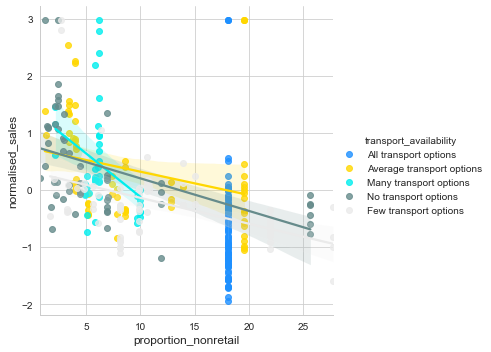

In [168]:
sns.lmplot(data= stores, x='proportion_nonretail', y= 'normalised_sales', hue= 'transport_availability')

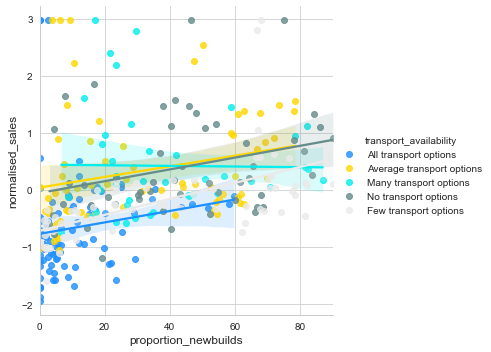

In [169]:
sns.lmplot(data= stores, x='proportion_newbuilds', y= 'normalised_sales', hue= 'transport_availability')

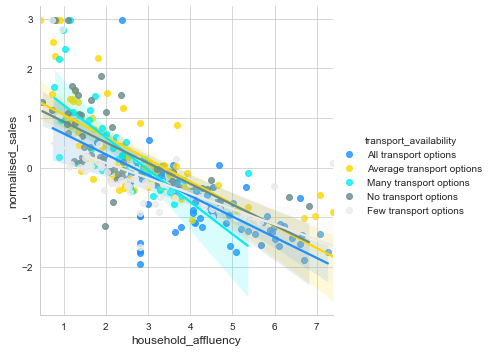

In [170]:
sns.lmplot(data= stores, x='household_affluency', y= 'normalised_sales', hue= 'transport_availability')

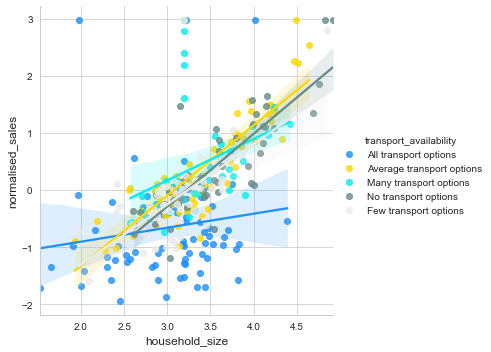

In [171]:
sns.lmplot(data= stores, x='household_size', y= 'normalised_sales', hue= 'transport_availability')

#### Observations from scatterplots and correlation matrix
-  Normalised sales trending down as household affluency goes up
-  Normalised sales trending up as household size goes up
-  When there are many transport options, normalised sales is trending up as the proportion of non retail commercial properties goes down
-  When there are few or no transport options, normalised sales is trending up as proportion of new buils goes up
-  With average transport options and increasing household size, normallised sales seems to be trending up.
-  With decreasing household affluency and many transport options, normalised sales is trending up.

<b>Concerns about the data:<br>
-  We can see that the commercial_property feature is missing about 10% of the data and school_proximity is missing about 20%.<br>
-  The balance for several variables.<br><br>

<b>Other useful information to collect:
-  What is the literacy level and educational level of the populations?<br>
-  What languages do they speak and what is the religious structure?<br>
-  Is the health Index weakening?<br>

## Q2

Build a model that can predict store sales based on the provided area features.<br>
Please show how you developed the model and report how well your model is performing.<br>
Constraint: Please use Random Forest as the model family to solve this problem.

-  <b>I will be using Distributed Random forest (h2o.ai)

In [172]:
# Import libraries
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()
#h2o.init(ip="localhost", port=54321)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM AdoptOpenJDK (build 11.0.5+10, mixed mode)
  Starting server from C:\Users\kci_2\Anaconda3\envs\ds_assessments\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kci_2\AppData\Local\Temp\tmpac978b1r
  JVM stdout: C:\Users\kci_2\AppData\Local\Temp\tmpac978b1r\h2o_kci_2_started_from_python.out
  JVM stderr: C:\Users\kci_2\AppData\Local\Temp\tmpac978b1r\h2o_kci_2_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_kci_2_6h57et
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.930 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [173]:
train = stores 
given_test = stores_test
print(train.shape)
#print(given_test.shape)
print(train.columns)
#print(given_test.columns)

(320, 16)
Index(['location_id', 'crime_rate', 'proportion_flats', 'proportion_nonretail',
       'new_store', 'commercial_property', 'household_size',
       'proportion_newbuilds', 'public_transport_dist',
       'transport_availability', 'property_value', 'school_proximity',
       'competitor_density', 'household_affluency', 'normalised_sales',
       'county'],
      dtype='object')


In [174]:
# Convert data into h2o Frame
train = h2o.H2OFrame(train)
given_test = h2o.H2OFrame(given_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [175]:
train.head()

location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
464,17.6005,0,18.1,no,9.4,2.926,29,2.9084,All transport options,666,20.2,368.74,4.5325,-0.399933,c_40
504,0.603556,20,3.97,no,14.85,4.52,10.6,2.1398,Average transport options,264,19.1,388.37,1.815,2.21631,c_80
295,0.60681,0,6.2,no,7.7,2.981,31.9,3.6715,Many transport options,307,17.4,378.35,2.9125,0.16692,c_53
187,0.0123848,55,2.25,no,1.95,3.453,68.1,7.3073,No transport options,300,15.3,394.72,2.0575,-0.0838035,c_65
193,0.0161816,75,1.32,no,3.05,3.816,59.5,8.3248,Average transport options,256,15.1,392.9,0.9875,0.962693,c_97
160,0.0686588,0,11.93,no,11.15,3.976,9,2.1675,No transport options,273,21,396.9,1.41,0.123316,c_69
43,0.254126,12.5,7.87,no,8.7,3.377,5.7,6.3467,Average transport options,311,15.2,392.52,5.1125,-0.846874,c_22
278,6.58113,0,18.1,no,9.1,3.242,35.3,3.4242,All transport options,666,20.2,396.9,2.685,0.0252065,c_54
387,17.9221,0,18.1,no,16.45,2.896,4.6,1.9096,All transport options,666,20.2,392.205,6.0975,-1.57724,c_51
98,5.43771,0,18.1,no,18.15,3.701,10,2.5975,All transport options,666,20.2,392.217,4.105,-0.69426,c_47


In [176]:
train["new_store"] = train["new_store"].asfactor()
train["transport_availability"] = train["transport_availability"].asfactor()
train["county"] = train["county"].asfactor()
given_test["new_store"] = given_test["new_store"].asfactor()
given_test["new_store"] = given_test["new_store"].asfactor()
given_test["county"] = given_test["county"].asfactor()

In [177]:
# Split the train dataset
train, valid, test = train.split_frame(ratios=[0.8, 0.15], seed=42)

In [178]:
# Seperate the target data and store it into y variable
y = 'normalised_sales'

# remove target and Id column from the dataset and store rest of the columns in X variable
X = list(train.columns)
X.remove(y)
X

['location_id',
 'crime_rate',
 'proportion_flats',
 'proportion_nonretail',
 'new_store',
 'commercial_property',
 'household_size',
 'proportion_newbuilds',
 'public_transport_dist',
 'transport_availability',
 'property_value',
 'school_proximity',
 'competitor_density',
 'household_affluency',
 'county']

In [179]:
##Random Forest Algorithm
# Prepare the hyperparameters
nfolds = 5
rf_params = {'max_depth': [3, 4, 5, 6, 7],
             'sample_rate': [0.8, 1.0],               # Row sample rate
             'mtries' : [3, 5, 4]
            }

In [180]:
# Search criteria for parameter space
search_criteria = {'strategy': "RandomDiscrete",
                   'seed': 1,
                   'stopping_metric': "AUTO",
                   'stopping_tolerance': 0.0005
                   }

In [181]:
# Prepare the grid object
rf_grid = H2OGridSearch(model=H2ORandomForestEstimator,      # Model to be trained
                        grid_id='rf_grid',                   # Grid Search ID
                        hyper_params=rf_params,              # Dictionary of parameters
                        search_criteria=search_criteria,       # RandomDiscrete
                        )

In [182]:
# Train the Model
start = time.time() 
rf_grid.train(x=X, y=y, 
              training_frame=train,
              validation_frame=valid,
              ntrees=500,      
              score_each_iteration=True,
              nfolds = nfolds,
              fold_assignment="Modulo",
              seed=1
             )

end = time.time()
(end - start)/60

drf Grid Build progress: |████████████████████████████████████████████████| 100%


3.985310645898183

In [183]:
# Find the Model performance 
rf_gridperf = rf_grid.get_grid(sort_by = 'RMSE', decreasing = False)
rf_gridperf

     max_depth mtries sample_rate         model_ids                rmse
0            7      3         1.0  rf_grid_model_27  0.5236949246908371
1            7      3         0.8  rf_grid_model_12   0.531862428518022
2            6      3         1.0   rf_grid_model_9  0.5329314615561423
3            6      3         0.8  rf_grid_model_25   0.537631882939232
4            7      4         1.0   rf_grid_model_6  0.5378028780654811
5            7      4         0.8  rf_grid_model_17  0.5405638347711392
6            6      4         1.0  rf_grid_model_26  0.5435942951552852
7            6      4         0.8   rf_grid_model_2  0.5450934470783682
8            5      3         1.0   rf_grid_model_5  0.5464018838439243
9            5      3         0.8  rf_grid_model_14  0.5481514246360396
10           7      5         1.0   rf_grid_model_3  0.5533620829463889
11           5      4         1.0  rf_grid_model_19  0.5542193552681641
12           5      4         0.8  rf_grid_model_30  0.554720019

In [184]:
# Identify the best model generated with least error
best_rf_model = rf_gridperf.models[0]
best_rf_model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_grid_model_27


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,500.0,500.0,550704.0,7.0,7.0,7.0,38.0,93.0,69.782




ModelMetricsRegression: drf
** Reported on train data. **

MSE: NaN
RMSE: NaN
MAE: NaN
RMSLE: NaN
Mean Residual Deviance: NaN

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.2264904972121279
RMSE: 0.47591017767235017
MAE: 0.30961191615832934
RMSLE: NaN
Mean Residual Deviance: 0.2264904972121279

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.2742563741469416
RMSE: 0.5236949246908371
MAE: 0.3370642037782082
RMSLE: NaN
Mean Residual Deviance: 0.2742563741469416

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.33740738,0.055020705,0.35049534,0.2916226,0.32966688,0.29067802,0.42457405
1,mean_residual_deviance,0.27467555,0.084611766,0.28831482,0.16479129,0.31950536,0.21962252,0.38114372
2,mse,0.27467555,0.084611766,0.28831482,0.16479129,0.31950536,0.21962252,0.38114372
3,r2,0.7121037,0.06831307,0.73954004,0.7490588,0.6019308,0.7759959,0.6939931
4,residual_deviance,0.27467555,0.084611766,0.28831482,0.16479129,0.31950536,0.21962252,0.38114372
5,rmse,0.51883,0.08284766,0.5369495,0.4059449,0.5652481,0.46863902,0.6173684
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-07-12 00:13:07,3 min 30.093 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-07-12 00:13:07,3 min 30.095 sec,1.0,NaN,NaN,NaN,0.384799,0.280892,0.148070
2,,2020-07-12 00:13:07,3 min 30.097 sec,2.0,NaN,NaN,NaN,0.448981,0.327116,0.201584
3,,2020-07-12 00:13:07,3 min 30.099 sec,3.0,NaN,NaN,NaN,0.498743,0.327136,0.248745
4,,2020-07-12 00:13:07,3 min 30.100 sec,4.0,NaN,NaN,NaN,0.519176,0.317046,0.269544
5,,2020-07-12 00:13:07,3 min 30.102 sec,5.0,NaN,NaN,NaN,0.522680,0.316242,0.273194
6,,2020-07-12 00:13:07,3 min 30.104 sec,6.0,NaN,NaN,NaN,0.548339,0.330278,0.300676
7,,2020-07-12 00:13:07,3 min 30.106 sec,7.0,NaN,NaN,NaN,0.513070,0.319298,0.263241
8,,2020-07-12 00:13:07,3 min 30.108 sec,8.0,NaN,NaN,NaN,0.485655,0.306027,0.235861
9,,2020-07-12 00:13:07,3 min 30.109 sec,9.0,NaN,NaN,NaN,0.486886,0.308194,0.237058



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,county,34545.746094,1.000000,0.297233
1,household_affluency,26704.589844,0.773021,0.229768
2,household_size,13931.758789,0.403284,0.119870
3,crime_rate,8096.850098,0.234381,0.069666
4,proportion_nonretail,7558.690430,0.218802,0.065035
5,property_value,5429.726562,0.157175,0.046718
6,public_transport_dist,4327.357910,0.125265,0.037233
7,commercial_property,3978.121582,0.115155,0.034228
8,school_proximity,3575.640869,0.103505,0.030765
9,proportion_newbuilds,3174.040527,0.091879,0.027310


In [185]:
## Model Performances
best_rf_perf = best_rf_model.model_performance(test)   # Random Forest Model

In [186]:
### Retreive test set AUC
print(best_rf_perf.gini)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 1.207687668470876
RMSE: 1.0989484375851652
MAE: 0.4200864555198246
RMSLE: 0.7924715359487782
Mean Residual Deviance: 1.207687668470876
<bound method MetricsBase.gini of >


In [187]:
## Prediction of Model
rf_pred = best_rf_model.predict(given_test).as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


In [188]:
rf_pred.head()
list(rf_pred['predict'])

[0.2679793974033091,
 1.152299728537444,
 -0.6022590442486108,
 0.02073062666156329,
 -1.2892556055784226,
 -0.9625482496507466,
 0.06847703778234426,
 0.04916072747856379,
 0.4811950186092872,
 0.21325716406689024,
 -0.5594082713127136,
 2.2028393733538687,
 -0.2712562157055363]

In [189]:
stores_test['predicted_normalised_sales'] = list(rf_pred['predict'])

In [190]:
## Submission to Tesco
sub = stores_test
sub['predicted_normalised_sales'] = list(rf_pred['predict'])
sub.head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,county,predicted_normalised_sales
0,105,0.039968,34.0,6.09,no,4.15,3.590,59.6,5.4917,Many transport options,329,16.1,395.75,2.3750,c_42,0.267979
1,400,0.587758,20.0,3.97,no,14.85,5.398,8.5,2.2885,Average transport options,264,13.0,386.86,1.4775,c_140,1.152300
2,338,1.116926,0.0,8.14,no,9.40,2.813,0.0,4.0952,Few transport options,307,NaN,394.54,4.9700,c_55,-0.602259
3,227,1.517409,0.0,19.58,no,12.75,3.066,0.0,1.7573,Average transport options,403,14.7,353.89,1.6075,c_62,0.020731
4,114,83.093533,0.0,18.10,no,16.45,2.957,0.0,1.8026,All transport options,666,20.2,16.45,5.1550,c_22,-1.289256


In [191]:
sub.to_csv('tesco_stores_predicted_normalised_sales.csv', index=False)

In [192]:
plot_rf_pred = best_rf_model.predict(test).as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


In [193]:
test_df = test.as_data_frame()
test_df['predicted_normalised_sales'] = plot_rf_pred['predict']
test_df.head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county,predicted_normalised_sales
0,282,0.385432,0,7.38,no,7.15,3.415,59.9,4.7211,Average transport options,287,19.6,396.900,1.5300,0.243227,c_85,0.099067
1,393,10.432499,0,18.10,no,14.05,3.216,0.0,1.1691,All transport options,666,20.2,392.205,2.3825,2.968477,c_138,-0.653189
2,321,0.061913,33,2.18,no,6.10,3.616,41.9,3.3700,Many transport options,222,18.4,393.360,2.2325,0.613861,c_90,0.564783
3,3,0.373408,0,6.20,no,7.85,3.086,38.5,3.6519,Many transport options,307,17.4,376.750,2.7200,0.134217,c_72,0.065185
4,354,0.020091,75,1.47,no,2.65,4.135,86.1,7.6534,No transport options,402,17.0,384.300,1.1125,1.104406,c_59,0.865336


#### Actual and predicted values

In [194]:
fig = px.scatter(test_df, x="location_id", y=["normalised_sales", "predicted_normalised_sales"])
fig.show()

#### Feature importance plot

In [73]:
# Get numerical feature importances
feature_list = list(X.columns.values)
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:.20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: household_affluency Importance: 0.37
Variable: county_cat Importance: 0.21
Variable: household_size Importance: 0.14
Variable: proportion_nonretail Importance: 0.06
Variable: public_transport_dis Importance: 0.05
Variable: commercial_property Importance: 0.04
Variable: proportion_newbuilds Importance: 0.03
Variable: property_value Importance: 0.03
Variable: crime_rate Importance: 0.02
Variable: school_proximity Importance: 0.02
Variable: location_id Importance: 0.01
Variable: proportion_flats Importance: 0.01
Variable: competitor_density Importance: 0.01
Variable: transport_availabili Importance: 0.01
Variable: new_store_cat Importance: 0.0


Text(0.5, 1.0, 'Variable Importances')

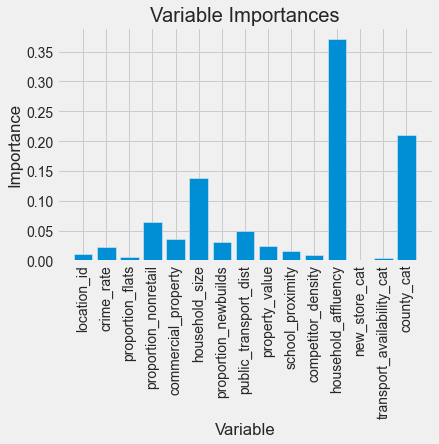

In [74]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

## Q3

Predict the sales value in the test dataset areas.<br> 
Make recommendations to stores team.<br>
Share your findings with product owners and other non-technical decision makers in the team.<br>
Improve the current results.

In [75]:
stores_test_encoded_all = stores_test_encoded

stores_test_encoded['commercial_property'] = stores_test_encoded['commercial_property'].fillna(stores_test_encoded['commercial_property'].median())
stores_test_encoded['school_proximity'] = stores_test_encoded['school_proximity'].fillna(stores_test_encoded['school_proximity'].median())

stores_test_encoded = stores_test_encoded.drop(['normalised_sales', 'new_store', 'transport_availability', 'county'], axis=1)
#stores_test_encoded

In [76]:
# make predictions on test set
test_predictions = []
for i in range(len(stores_test_encoded)):
    yhat1 = model.predict([stores_test_encoded.values.tolist()[i]])
    test_predictions.append(yhat1[0])
print(test_predictions)

[0.19624325564451164, 1.9072646439856265, -0.7565479868794839, 0.21835048917888925, -1.4628239536902599, -0.9761377858521113, 0.1563019816455197, 1.316670118134806, 0.8252311131068075, 0.32716429841959327, -0.6412153780068466, 2.592959517644086, -0.31036994518222516]


In [77]:
stores_test_predicted = stores_test_encoded
stores_test_predicted['predicted_normalised_sales'] = test_predictions
stores_test_predicted

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,property_value,school_proximity,competitor_density,household_affluency,new_store_cat,transport_availability_cat,county_cat,predicted_normalised_sales
0,105,0.039968,34.0,6.09,4.150,3.590,59.6,5.4917,329.0,16.1,395.75,2.3750,0,3,43,0.196243
1,400,0.587758,20.0,3.97,14.850,5.398,8.5,2.2885,264.0,13.0,386.86,1.4775,0,1,16,1.907265
2,338,1.116926,0.0,8.14,9.400,2.813,0.0,4.0952,307.0,17.9,394.54,4.9700,0,2,56,-0.756548
3,227,1.517409,0.0,19.58,12.750,3.066,0.0,1.7573,403.0,14.7,353.89,1.6075,0,1,63,0.218350
4,114,83.093533,0.0,18.10,16.450,2.957,0.0,1.8026,666.0,20.2,16.45,5.1550,0,0,23,-1.462824
5,203,10.988323,0.0,18.10,19.500,3.406,2.8,2.0651,666.0,20.2,385.96,4.8800,0,0,20,-0.976138
6,12,0.159895,0.0,6.91,4.900,3.169,93.4,5.7209,233.0,17.9,383.37,1.4525,0,4,64,0.156302
7,199,9.341992,0.0,18.10,15.900,2.875,10.4,1.1296,666.0,20.2,347.88,2.2200,1,0,3,1.316670
8,477,0.010238,90.0,2.97,2.500,4.088,79.2,7.3073,285.0,15.3,394.72,1.9625,0,4,70,0.825231
9,341,0.216802,0.0,7.38,7.150,3.431,85.3,5.4159,287.0,19.6,393.68,1.2700,0,1,59,0.327164


In [78]:
stores_test_predicted_no_cat = stores_test_predicted
stores_test_predicted_no_cat = stores_test_predicted_no_cat.drop(['new_store_cat', 'transport_availability_cat', 'county_cat'], axis=1)
stores_test_predicted_no_cat['new_store'] = stores_test_encoded_all['new_store']
stores_test_predicted_no_cat['transport_availability'] = stores_test_encoded_all['transport_availability']
stores_test_predicted_no_cat['county'] = stores_test_encoded_all['county']
#stores_test_predicted_no_cat

#### Recomendations to Store Team and improvements
-  The mean absolute error for the model is -0.271, the predictions that are in excess of +/- 0.3 should be ok.
-  Improvement: Use a regressor that does not need to encode categorical variables
-  Improvement: Use randomized search to find better parameters for the model.
-  Try predicting the missing values from commercial property and school proximity instead of median

In [79]:
stores.to_csv('stores_main.csv', encoding='utf-8', index=False)
stores_test_predicted_no_cat.to_csv('stores_test.csv', encoding='utf-8', index=False)

## Q4

Train model on masked data and predict target y.<br>
Explain steps.<br>
Provide comments to business assuming model would be used to make decisions involving important sums of money.

In [80]:
# Load data
masked = pd.read_csv('../masked_dataset/train.csv')

In [81]:
#masked.head()
masked.describe()

,x1,x2,y
count,100.000000,100.000000,100.000000
mean,0.444403,0.523374,0.554952
std,0.288595,0.291111,0.421430
min,0.000457,0.012779,-0.191714
25%,0.222642,0.265002,0.222144
50%,0.401859,0.527564,0.519598
75%,0.682649,0.784647,0.879761
max,0.996337,0.949549,1.499445


In [82]:
value_count(masked, 'NA')

{'x1': [0, '0.00%'], 'x2': [0, '0.00%'], 'y': [0, '0.00%']}

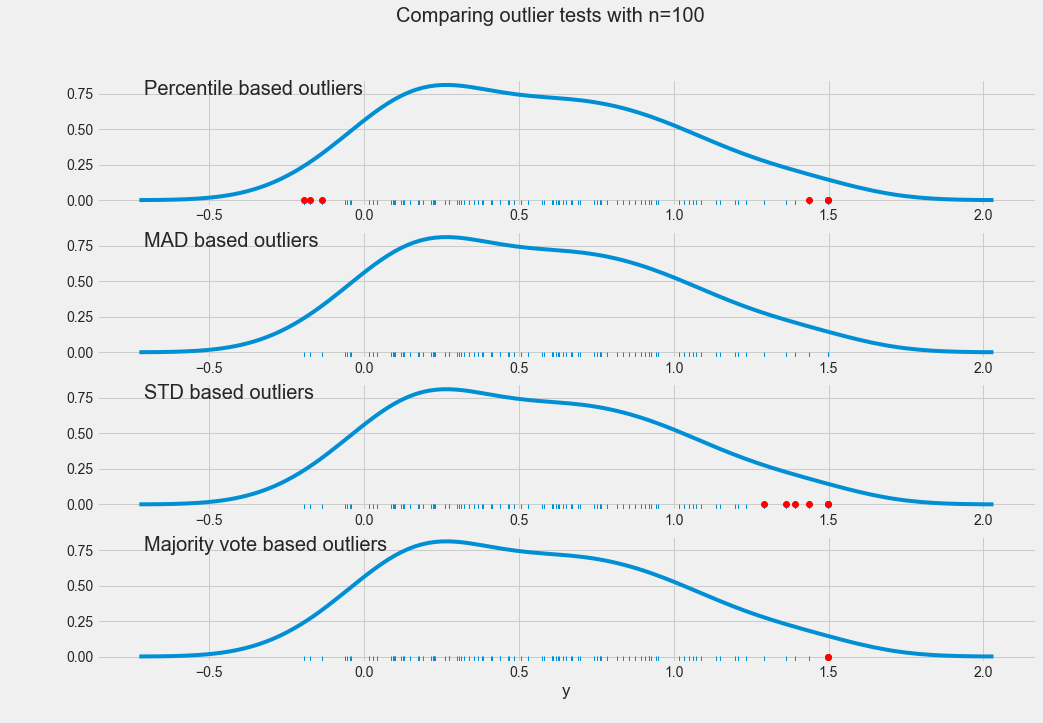

In [83]:
plot_outlier(masked.y.sample(100))

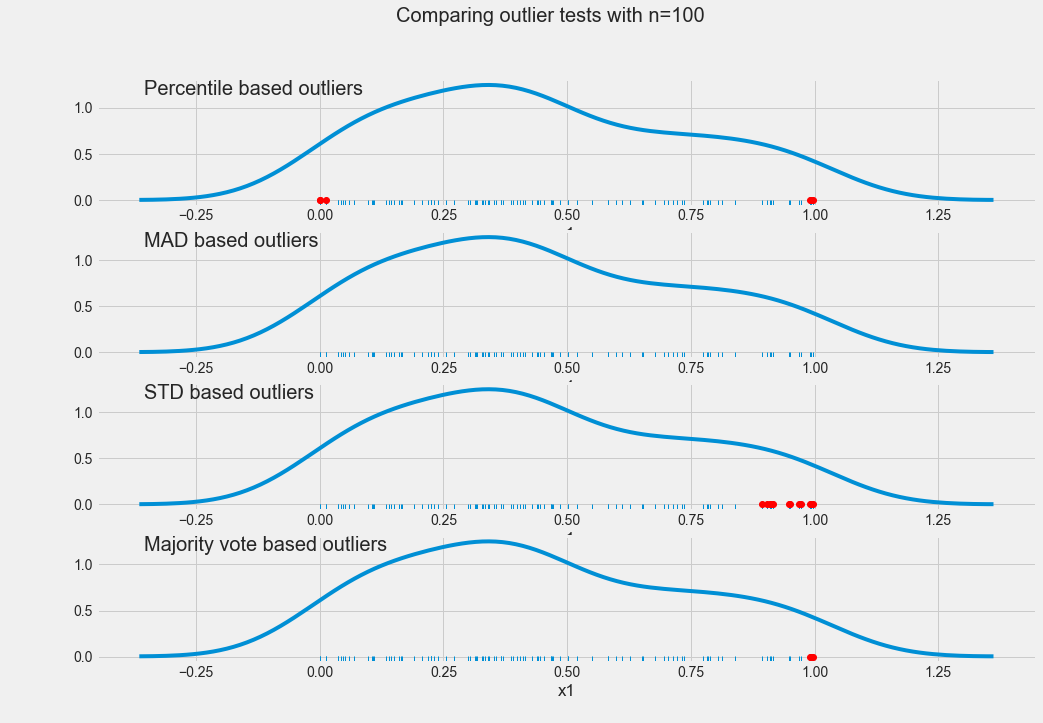

In [84]:
plot_outlier(masked.x1.sample(100))

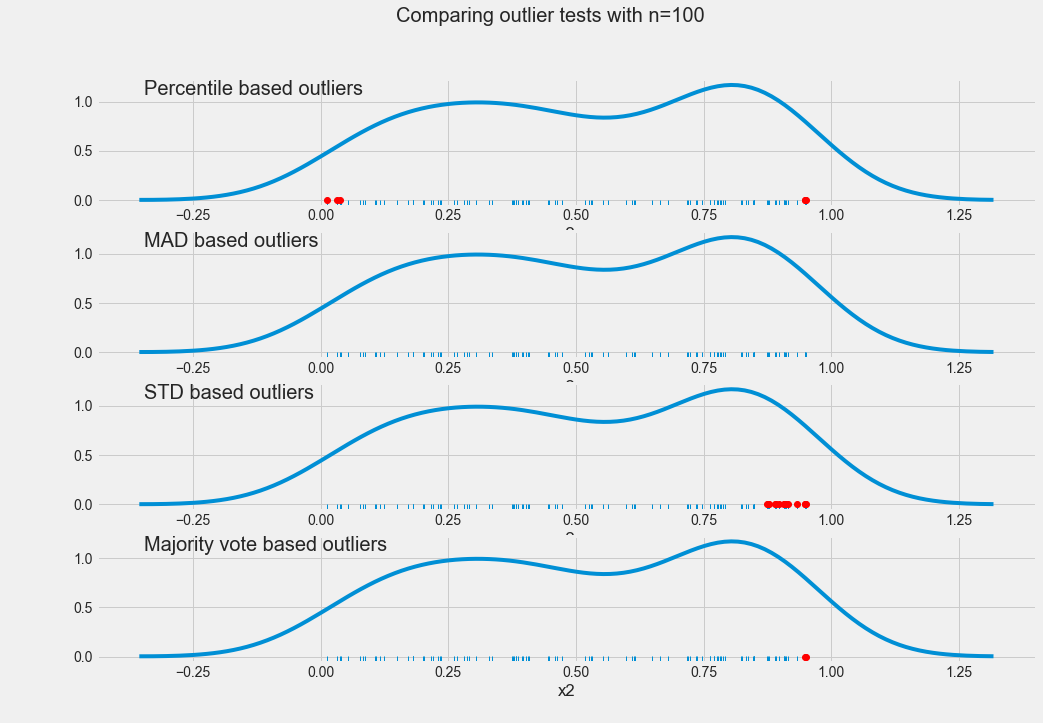

In [85]:
plot_outlier(masked.x2.sample(100))

In [86]:
outlier_ratio(masked.y)

{'percentile_based_outlier': [6, '6.00%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [6, '6.00%'],
 'outlier_vote': [2, '2.00%']}

In [87]:
outlier_ratio(masked.x1)

{'percentile_based_outlier': [6, '6.00%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [12, '12.00%'],
 'outlier_vote': [3, '3.00%']}

In [88]:
outlier_ratio(masked.x2)

{'percentile_based_outlier': [6, '6.00%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [15, '15.00%'],
 'outlier_vote': [2, '2.00%']}

In [89]:
fig = px.box(masked, y="x1", points='all')
fig.show()

In [90]:
fig = px.box(masked, y="x2", points='all')
fig.show()

In [91]:
for num in masked.columns:
    hist_data = [masked[num]]
    group_labels = [num]
    fig = ff.create_distplot(hist_data, group_labels)
    fig.show()

In [92]:
masked.corr()

,x1,x2,y
x1,1.000000,0.061202,0.536305
x2,0.061202,1.000000,0.705965
y,0.536305,0.705965,1.000000


In [93]:
fig = px.scatter_matrix(masked)
fig.show()

-  We can see an upward trend for x1 and x2
-  Add columns to form potential additional features and evaluate with correlation

In [94]:
masked['sum_x1_x2'] = masked['x1'] + masked['x2']

In [95]:
masked.corr()

,x1,x2,y,sum_x1_x2
x1,1.000000,0.061202,0.536305,0.725620
x2,0.061202,1.000000,0.705965,0.731215
y,0.536305,0.705965,1.000000,0.853210
sum_x1_x2,0.725620,0.731215,0.853210,1.000000


#### Check feature importance

In [96]:
X = masked.drop(['y'], axis=1)
y = masked['y'].copy()

In [97]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

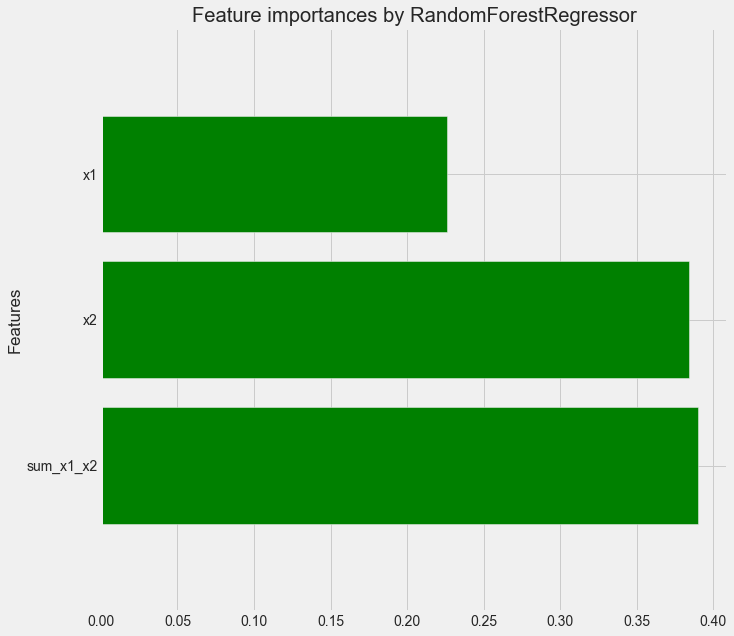

In [98]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(X, y)
feature_names = X.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:10]

plt.subplots(figsize=(10,10))
plt.title("Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.show()

In [99]:
# Set the style
plt.style.use('fivethirtyeight')

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:10]

# list of x locations for plotting
x_values = list(range(len(importances[indices])))
# Make a bar chart
plt.bar(x_values, importances[indices], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_names[indices], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

Text(0.5, 1.0, 'Variable Importances')

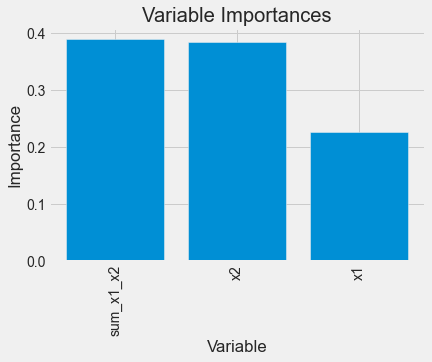

In [100]:
class cluster_target_encoder:
    def __init__(self,nclusters=4,seed=0):
        self.seed= seed
        self.nclusters= nclusters
    def make_encoding(self,df):
        self.encoding = df.groupby('X')['y'].mean() #this will return the mean of output variable grouped by category
    def fit(self,X,y):
        df = pd.DataFrame(columns=['X','y'],index=X.index)
        df['X'] = X
        df['y'] = y
        self.make_encoding(df)
        clust = KMeans(self.nclusters,random_state=self.seed)
        #self.encoding[df['X'].values].values--> this will return the mean value of the output variable for each datapoint based on its category
        labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
        df['labels'] = labels
        self.clust_encoding = df.groupby('X')['labels'].median()
    def transform(self,X):
        #X.map(self.clust_encoding).astype(float)--> this will return the group mean as output variable for the category input
        res = X.map(self.clust_encoding).astype(float)
        return res
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

Populating the interactive namespace from numpy and matplotlib


C:\Users\kci_2\Anaconda3\envs\ds_assessments\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['axes', 'randint', 'std', 'norm', 'f', 'indices']
`%matplotlib` prevents importing * from pylab and numpy



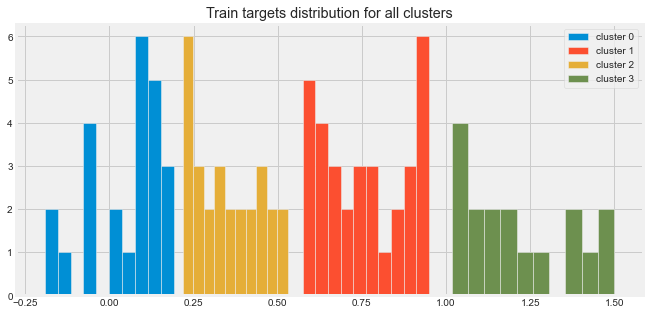

In [101]:
enc1 = cluster_target_encoder()
labels_train = enc1.fit_transform(X['x2'], y)
#labels_test = enc1.fit_transform(X_test['x2'], y_test)
#labels_test = enc1.transform(X_test['x2'])
%pylab inline
plt.figure(figsize(10,5))
plt.hist(y.values[labels_train==0],bins=10,label='cluster 0')
plt.hist(y.values[labels_train==1],bins=10,label='cluster 1')
plt.hist(y.values[labels_train==2],bins=10,label='cluster 2')
plt.hist(y.values[labels_train==3],bins=10,label='cluster 3')
plt.legend()
plt.title('Train targets distribution for all clusters')
#plt.xlim((60,170))
plt.show()

In [102]:
labels_train.head()

0    3.0
1    1.0
2    3.0
3    2.0
4    1.0
Name: x2, dtype: float64

In [103]:
X['labels']=labels_train
#X_test['labels']=labels_test
X.head()

,x1,x2,sum_x1_x2,labels
0,0.784119,0.948352,1.732472,3.0
1,0.911072,0.787079,1.698150,1.0
2,0.549740,0.906819,1.456559,3.0
3,0.036095,0.791149,0.827244,2.0
4,0.581530,0.609205,1.190736,1.0


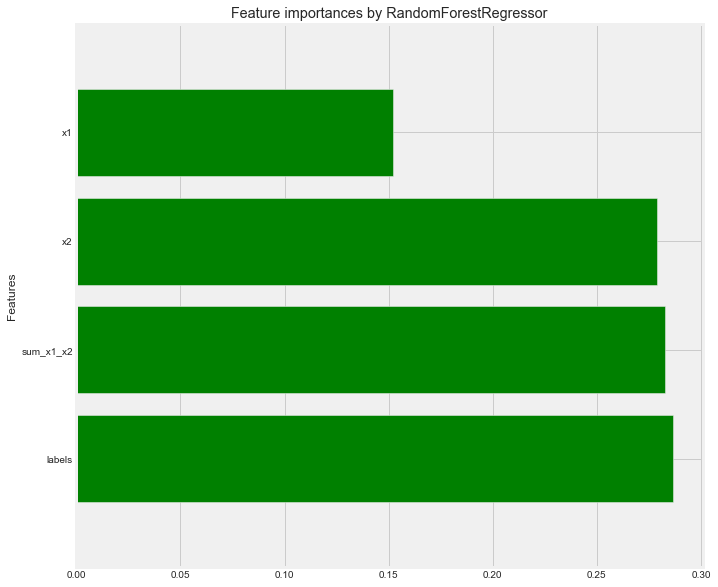

In [104]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(X, y)
feature_names = X.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:10]

plt.subplots(figsize=(10,10))
plt.title("Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.show()

#### Models
split here


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [106]:
def cvDictGenR(functions, scr, X_train=X_train, y_train=y_train, cv=3, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    return cvDict

def cvDictNormalizeR(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[list(cvDict.keys())[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[list(cvDict.keys())[0]][1]))]
    return cvDictNormalized

In [107]:
lmMod = LinearRegression(fit_intercept=True, normalize=True).fit(X_train, y_train)

In [108]:
adaMod = AdaBoostRegressor(base_estimator=None, n_estimators=100, learning_rate=1.0, loss='linear')

In [109]:
gbMod = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=300, subsample=1.0, min_samples_split=2,
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, init=None,
                                  random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None,
                                  warm_start=False)

In [110]:
rfMod = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                              min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True,
                              oob_score=False, n_jobs=1, random_state=None, verbose=1)

In [111]:
knnMod = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30,
                             p=2, metric='minkowski', metric_params=None)

In [112]:
cvDict = cvDictGenR(functions=[lmMod, adaMod, gbMod, rfMod, knnMod], scr = 'r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_j

In [113]:
cvDict

{'LinearRegression': [0.7883097621515889, 0.043602632155514194],
 'AdaBoostRegressor': [0.8862337018087022, 0.02716386470204516],
 'GradientBoostingRegressor': [0.8716650679418833, 0.019833920183857885],
 'RandomForestRegressor': [0.8491211125321311, 0.009757761427544092],
 'KNeighborsRegressor': [0.8949129671430235, 0.026210970770918034]}

In [114]:
cvDictNormalizeR(cvDict)

{'LinearRegression': ['1.00', '1.00'],
 'AdaBoostRegressor': ['1.12', '0.62'],
 'GradientBoostingRegressor': ['1.11', '0.45'],
 'RandomForestRegressor': ['1.08', '0.22'],
 'KNeighborsRegressor': ['1.14', '0.60']}

Try ADA hyper tuning

In [115]:
adaHyperParams = {'n_estimators': [10, 50, 100, 200, 400, 1000]}

In [116]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=adaHyperParams, n_iter=10,
                                   scoring='r2', cv=None, verbose=2).fit(X_train, y_train)

C:\Users\kci_2\Anaconda3\envs\ds_assessments\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.0s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.0s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.0s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.0s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.0s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   0.1s
[CV] n_estimators=50 .................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished


In [117]:
gridSearchAda.best_params_, gridSearchAda.best_score_

({'n_estimators': 200}, 0.9118399316558049)

In [118]:
#gbHyperParams = {'loss': 'lad', 'n_estimators': 500, 'max_depth': randint(1,10)}
gbHyperParams = {'n_estimators': [2000], 'max_depth': [10], 'min_samples_split': [5], 'learning_rate': [0.01], 'loss': ['lad']}

In [119]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='r2', cv=None, verbose=2).fit(X_train, y_train)

C:\Users\kci_2\Anaconda3\envs\ds_assessments\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01 
[CV]  n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01, total=   3.7s
[CV] n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01, total=   3.6s
[CV] n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01 
[CV]  n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01, total=   3.7s
[CV] n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01 
[CV]  n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01, total=   3.5s
[CV] n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01 
[CV]  n_estimators=2000, min_samples_split=5, max_depth=10, loss=lad, learning_rate=0.01, total=   3.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.0s finished


In [120]:
gridSearchGB.best_params_, gridSearchGB.best_score_

({'n_estimators': 2000,
  'min_samples_split': 5,
  'max_depth': 10,
  'loss': 'lad',
  'learning_rate': 0.01},
 0.8646168573167303)

In [121]:
knnHyperParams = {'n_neighbors': [randint(3, 5)], 'leaf_size': [randint(20, 50)]}

In [122]:
gridSearchKnn = RandomizedSearchCV(estimator=knnMod, param_distributions=knnHyperParams, n_iter=10,
                                   scoring='r2', cv=None, verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_neighbors=3, leaf_size=45 .....................................
[CV] ...................... n_neighbors=3, leaf_size=45, total=   0.0s
[CV] n_neighbors=3, leaf_size=45 .....................................
[CV] ...................... n_neighbors=3, leaf_size=45, total=   0.0s
[CV] n_neighbors=3, leaf_size=45 .....................................
[CV] ...................... n_neighbors=3, leaf_size=45, total=   0.0s
[CV] n_neighbors=3, leaf_size=45 .....................................
[CV] ...................... n_neighbors=3, leaf_size=45, total=   0.0s
[CV] n_neighbors=3, leaf_size=45 .....................................
[CV] ...................... n_neighbors=3, leaf_size=45, total=   0.0s


C:\Users\kci_2\Anaconda3\envs\ds_assessments\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [123]:
gridSearchKnn.best_params_, gridSearchKnn.best_score_

({'n_neighbors': 3, 'leaf_size': 45}, 0.8972411137050192)

In [124]:
rfHyperParams = {'max_depth': (2, 3, 4, 5, 6, 8, 10), 'max_features': [0.2, 0.3, 0.4, 0.5], 'min_samples_leaf': [2, 4, 6, 10],
                 'n_estimators': [50, 100, 200, 250, 300, 350, 400,
                                          500, 1000]},

In [125]:
gridSearchRf = RandomizedSearchCV(estimator=rfMod, param_distributions=rfHyperParams, n_iter=10,
                                   scoring='r2', cv=None, verbose=2).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_leaf=10, max_features=0.4, max_depth=6, total=   1.0s
[CV] n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2 


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2, total=   0.3s
[CV] n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2 


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2, total=   0.2s
[CV] n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2 


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2, total=   0.2s
[CV] n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2 


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2, total=   0.3s
[CV] n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2 


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=250, min_samples_leaf=2, max_features=0.4, max_depth=2, total=   0.3s
[CV] n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6, total=   0.4s
[CV] n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6, total=   0.4s
[CV] n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6, total=   0.4s
[CV] n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6, total=   0.4s
[CV] n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6 


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_leaf=4, max_features=0.4, max_depth=6, total=   0.4s
[CV] n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2 
[CV]  n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2 


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV]  n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV]  n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2 
[CV]  n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[CV]  n_estimators=200, min_samples_leaf=4, max_features=0.5, max_depth=2, total=   0.2s
[CV] n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6 
[CV]  n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6, total=   0.1s
[CV] n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6 


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6, total=   0.1s
[CV] n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6 
[CV]  n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6, total=   0.1s
[CV] n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6 


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6, total=   0.1s
[CV] n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6 
[CV]  n_estimators=100, min_samples_leaf=2, max_features=0.3, max_depth=6, total=   0.1s
[CV] n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10 
[CV]  n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV]  n_estimators=200, min_samples_leaf=2, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   1.0s
[CV] n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   1.0s
[CV] n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   0.9s
[CV] n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10 
[CV]  n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV]  n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10 
[CV]  n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV]  n_estimators=200, min_samples_leaf=6, max_features=0.4, max_depth=10, total=   0.2s
[CV] n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8, total=   1.0s
[CV] n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[CV]  n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_leaf=2, max_features=0.3, max_depth=8, total=   0.9s
[CV] n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8 


[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8, total=   0.4s
[CV] n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8 


[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8, total=   0.4s
[CV] n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8 


[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8, total=   0.3s
[CV] n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8 


[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8, total=   0.3s
[CV] n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8 


[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.6s finished


[CV]  n_estimators=350, min_samples_leaf=4, max_features=0.5, max_depth=8, total=   0.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished


In [126]:
gridSearchRf.best_params_, gridSearchRf.best_score_

({'n_estimators': 1000,
  'min_samples_leaf': 2,
  'max_features': 0.3,
  'max_depth': 8},
 0.8516130274737895)

In [127]:
bestKnnModFitted = gridSearchKnn.best_estimator_.fit(X_train, y_train)

In [128]:
pred_list = list(bestKnnModFitted.predict(X_test))

In [129]:
bestKnnModFitted.score(X_test, y_test)

0.8963986685298603

In [130]:
pred_list

[0.6510937775950301,
 1.140674427563983,
 0.6234688521948653,
 1.2427881730393955,
 0.37512731222308915,
 1.3293302478699274,
 0.7630207522694533,
 1.1170146073026146,
 0.36452435807838607,
 1.2551811855322286,
 0.4426967304215928,
 0.7616896331300267,
 0.04552185708156342,
 0.7498748271616628,
 0.7498748271616629,
 0.6716540239209036,
 0.4426967304215928,
 1.2420241363385773,
 1.3293302478699276,
 0.1616183855360212]

In [131]:
test_list = y_test.to_list()

In [132]:
abs_list = []
for i in range(len(test_list)):
    abs_list.append(abs(test_list[i] - pred_list[i]))
abs_list
    

[0.00747034139938918,
 0.06906328611742518,
 0.19491872320333747,
 0.04770816250430876,
 0.037583646148382666,
 0.17011473292768553,
 0.15683296199082586,
 0.0313032466725347,
 0.03994986386511412,
 0.18222887399169774,
 0.07400431109210659,
 0.13282560327719595,
 0.04894691454446358,
 0.11960200560408485,
 0.01293478132494208,
 0.16496564387159118,
 0.023760723528063576,
 0.1914077026495964,
 0.26763633101192896,
 0.20665653324474786]

In [133]:
res_list = pd.DataFrame({'test y': test_list, 'pred y': pred_list})

In [134]:
#pred.plot(x="location_id", y=["normalised_sales", "predicted_normalised_sales"], style=['o', 'rx'])
fig = px.scatter(res_list, y=["test y", "pred y"])
fig.show()